In [14]:
# 余分な Warning を非表示にする
import warnings

warnings.filterwarnings('ignore')

# Library の Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import pydotplus

# matplotlib 日本語化対応
import japanize_matplotlib

# DataFrame 表示用関数
from IPython.display import display
from IPython.display import Image

# 表示 Option の調整
np.set_printoptions(suppress=True, precision=4)  # NumPy の浮動小数点の表示精度
pd.options.display.float_format = '{:.4f}'.format  # pandas での浮動小数点の表示精度
pd.set_option('display.max_columns', None)  # DataFrame ですべての項目を表示
plt.rcParams['font.size'] = 14  # Graph の Default font 指定
random_seed = 123  # 乱数の種

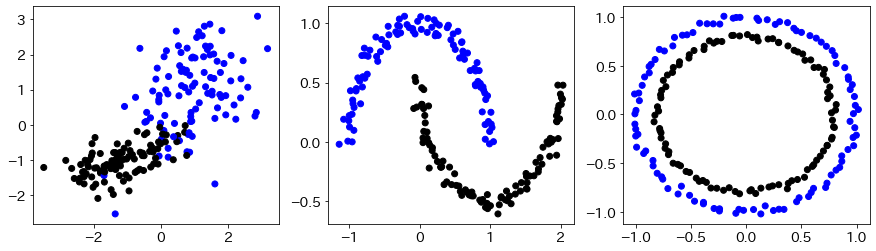

In [2]:
# 線形分離型
X1, y1 = make_classification(n_features=2, n_redundant=0, n_informative=2, random_state=random_seed,
                             n_clusters_per_class=1, n_samples=200, n_classes=2)

# 三日月型
X2, y2 = make_moons(noise=0.05, random_state=random_seed, n_samples=200)

# 円形（線形分離型）
X3, y3 = make_circles(noise=0.02, random_state=random_seed, n_samples=200)

# ３種類の Data を DataList に保存
DataList = [(X1, y1), (X2, y2), (X3, y3)]

# N: Data の種類数
N = len(DataList)

# 散布図表示
plt.figure(figsize=(15, 4))

# Color map 定義
cmap = ListedColormap(['#0000FF', '#000000'])

for i, data in enumerate(DataList):
    X, y = data
    ax = plt.subplot(1, N, i + 1)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)

plt.show()

### 解説

#### 最初の Data
**線形分離可能**と呼ばれ、直線を引くことで Group 分けが可能な Type.境界付近では若干 Data が混在し、完全にきれいには分類できないようになっている。
#### 真ん中の Data
直線では Group 分けできない Type。**「線形分離不可」** と呼ぶことがある。
#### 最後の Data
より複雑な Data で **「線形分離不可」** の Type となる。

### 実務
- 「線形分離可能」な Type において境界付近の混在している Data に対して、各Algorithm がどのような振る舞いをするのかが確認すべき Point の１つ。
- 「線形分離不可」のような複雑な Data に対応可能かどうか、というのも Algorithm の選択 Point の１つとなる。

In [3]:
# 決定境界線の表示関数
def plot_boundary(ax, x, y, algorithm):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=random_seed)
    # Color map 定義
    from matplotlib.colors import ListedColormap
    cmap1 = plt.cm.bwr
    cmap2 = ListedColormap(['#0000ff', '#000000'])

    h = 0.005
    algorithm.fit(x_train, y_train)
    score_test = algorithm.score(x_test, y_test)
    score_train = algorithm.score(x_train, y_train)
    f1_min = x[:, 0].min() - 0.5
    f1_max = x[:, 0].max() + 0.5
    f2_min = x[:, 1].min() - 0.5
    f2_max = x[:, 1].max() - 0.5
    f1, f2 = np.meshgrid(np.arange(f1_min, f1_max, h), np.arange(f2_min, f2_max, h))
    if hasattr(algorithm, 'decision_function'):
        z = algorithm.decision_function(np.c_[f1.ravel(), f2.ravel()])
        z = z.reshape(f1.shape)
        ax.contour(f1, f2, z, levels=[0], linewidth=2)
    else:
        z = algorithm.predict_proba(np.c_[f1.ravel(), f2.ravel()])[:, 1]
        z = z.reshape(f1.shape)
    ax.contour(f1, f2, z, cmap=cmap1, alpha=0.3)
    ax.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap=cmap2)
    ax.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=cmap2, marker='x')
    text = f'検証: {score_test:.2f} 訓練: {score_train:.2f}'
    ax.text(f1.max() - 0.3, f2.min() + 0.3, text, horizontalalignment='right', fontsize=18)


In [4]:
# 散布図と決定境界の表示関数
def plot_boundaries(algorithm, DataList):
    plt.figure(figsize=(15, 3))
    for i, data in enumerate(DataList):
        x, y = data
        ax = plt.subplot(1, N, i+1)
        plot_boundary(ax, x, y, algorithm)
    plt.show()

## Logistic 回帰
Algorithm の大まかな流れ
1. 入力変数に１次関数をかけて中間の値 ｕ を計算する。
2. １次関数の計算結果 ｕ を **「Sigmoid」**と呼ばれる関数にかける。この関数は、0 ~ 1 の値をとるので確率値と解釈する。
3. 確率値 y の値が 0.5 より大きい場合は値１を、0.5 より小さい場合は値０を予測結果とする。

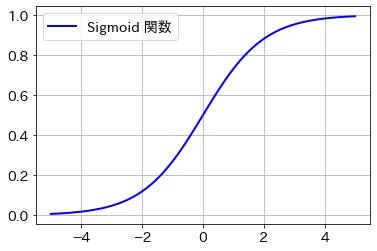

In [5]:
# Sigmoid 関数の定義
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# x の Data 準備
x = np.linspace(-5, 5, 101)

# y の Data 準備
y = sigmoid(x)

# Graph 表示
plt.plot(x, y, label='Sigmoid 関数', c='b', lw=2)

# 凡例表示
plt.legend()

# 方眼表示
plt.grid()

# Graph 描画
plt.show()

### Sigmoid 関数の性質
- 単調関数である（値が単調に増え続ける）
- 値が０から１の間をとる
- Graph にすると点対称な形になり、対称の中心座標は x=0, y=0.5 の点

上記の性質から確率値として扱える。
入力 Data が負の大きな値だと確率は０に近づき正の大きな値だと１に近づく

LogisticRegression(random_state=123)


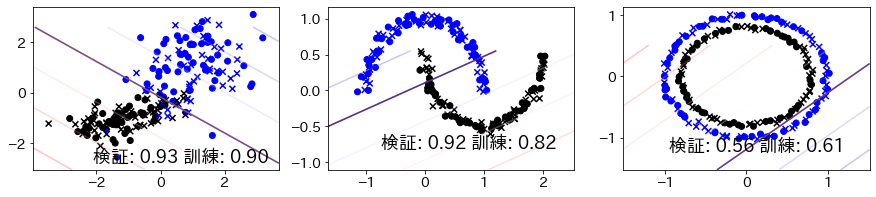

In [6]:
# Logistic 回帰の散布図・分類結果表示

# Algorithm 選択
algorithm = LogisticRegression(random_state=random_seed)

# Algorithm の持つ Parameters の表示
print(algorithm)

# 表示関数の呼び出し
plot_boundaries(algorithm, DataList)

- 左端の線形分離可能な Type に関しては、検証 Data, 訓練 Data ともにほぼ同等の精度が出ていて、汎用性の高い Model ができた。
- 右端の Sample data は、そもそも Data の構造が直線での Group 分けに向いていないため、良い境界線を見つけることができず。精度も低い結果となった。

## Support Vector Machine（Kernel）
分類の境界線を直線でうまく区切れない分布に対して考案された Algorithm.

### Kernel 法の１番基本的な考え方
２次元の入力 Data からできた点を３次元の世界に拡張し平面で２つの Group に分ける。


SVC()


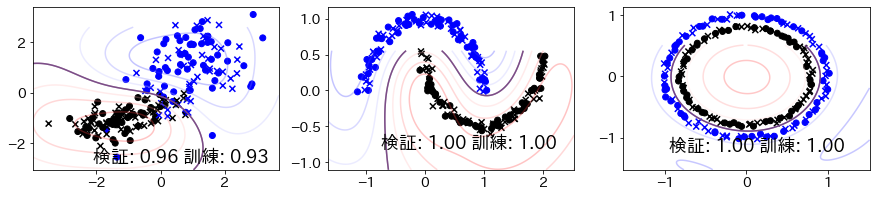

In [7]:
# SVM（Kernel）の散布図・分類結果表示

# Algorithm の選択
from sklearn.svm import SVC
algorithm = SVC(kernel='rbf')

# Algorithm の持つ Parameters の表示
print(algorithm)

# 表示関数の呼び出し
plot_boundaries(algorithm, DataList)

Logistic 回帰ではうまくいかなかった
- 中央
- 右端

の結果が、どちらも Data の特性に対応したきれいな決定境界になった。

## Neural Network
脳の神経細胞（Neuron）の Network を模して作られた Algorithm.
脳細胞間の結合を介して学習が進む。

<small>
数学的な仕組みでいうと、Logistic 回帰 Model に隠れ層 Node を増やしたものに相当する。
</small>

隠れ層が１層だけではなく、２層、３層とより複雑にしていったものが**Deep learning**.

<small>
隠れ層が１層のみのものに限って Neural Network と呼ぶことがある。
</small>

MLPClassifier(random_state=123)


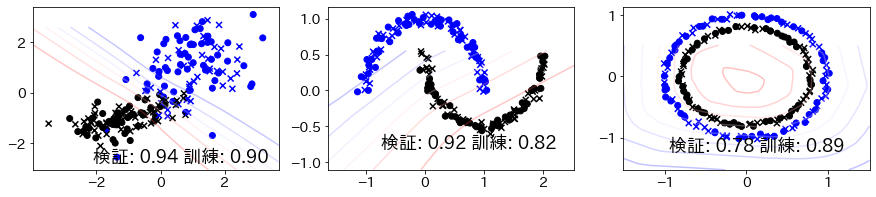

In [8]:
# Neural Network の散布図・分類結果表示

# Algorithm の選択
from sklearn.neural_network import MLPClassifier
algorithm = MLPClassifier(random_state=random_seed)

# Algorithm の持つ Parameters の表示
print(algorithm)

# 表示関数の呼び出し
plot_boundaries(algorithm, DataList)

中央、右端について確かに境界線は直線でなくなっているが、まだ元の Data に十分に適合しているとはいえない。

Parameters のういち隠れ層を２階層にしてみる。（隠れ層の Node 数を(100, 100)に変更してみる）

MLPClassifier(hidden_layer_sizes=(100, 100), random_state=123)


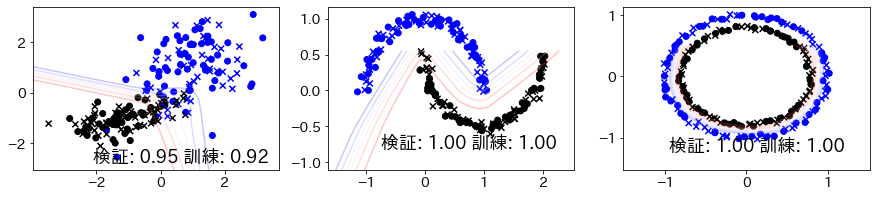

In [9]:
# Neural Network の散布図・分類結果表示

# Algorithm の選択
# 隠れ層 Node 数 = (100, 100)
algorithm = MLPClassifier(hidden_layer_sizes=(100, 100), random_state=random_seed)

# Algorithm の持つ Parameters の表示
print(algorithm)

# 表示関数の呼び出し
plot_boundaries(algorithm, DataList)

中央、右端の Data に対して検証 Data も100％の精度がでた。検証100％だが、過学習ではない、汎用性の高い Model ができたことを意味している。

<small>
Neural Network（Deep learning）の汎化能力の高さを示している。
</small>

## 決定木

In [10]:
# Sample data の読み込み
df_iris = sns.load_dataset('iris')

# ２種類の花に絞り込み
df2 = df_iris[50:150]

# Data 分離
X = df2.drop('species', axis=1)
y = df2['species']

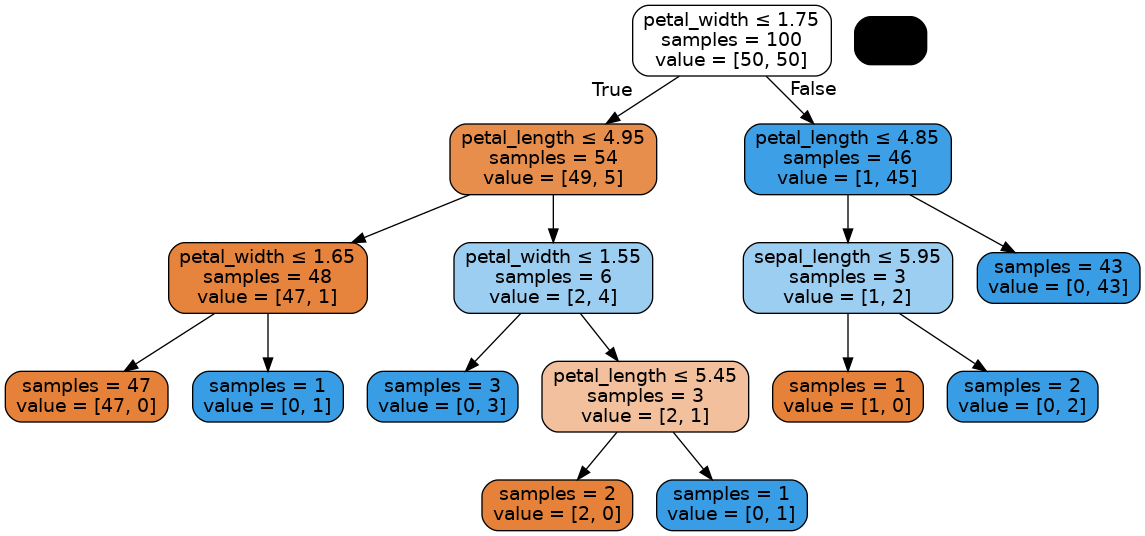

In [11]:
# 学習
algorithm = DecisionTreeClassifier(random_state=random_seed)
algorithm.fit(X, y)

# 決定木の Tree 表示
with open('iris-dtree.dot', mode='w') as f:
    tree.export_graphviz(algorithm, out_file=f, feature_names=X.columns, filled=True, rounded=True, special_characters=True, impurity=False, proportion=False)

graph = pydotplus.graphviz.graph_from_dot_file('dump/iris-dtree.dot')
graph.write_png('dump/iris-dtree.png')
Image(graph.create_png())

### 決定木 Model 内部の分岐の様子を Graph化し何を行なっているか確認

頂上の valueの値から初期状態では50個ずつ含まれていることが確認できる。

- petal_length（花弁長）
- petal_width（花弁幅）
- sepal_length（がく片長）
- sepal_width（がく片幅）

４つの入力項目から最初に「petal_width」に着目し、その値が「1.75」より大きいかどうかで Group 分けをしている。
2行目の value の値から最初の Group 分けでかなりの部分はきれいに分けられていることが確認できる。

以下、同様に「対象項目」と「閾値」を設定して、その値の大小で詳細な Group 分けをしていく。

決定木 Model は人間にわかりやすい Algorithm になる。

#### 決定木のどこが機械学習なのか？

- 判断対象の項目
- 基準の閾値の選択

上記を自動的に選択する点が機械学習になる。
<small>この判断基準を決めるための方式にも「Gini 不純度」「Entropy」などいくつかある。</small>

DecisionTreeClassifier(random_state=123)


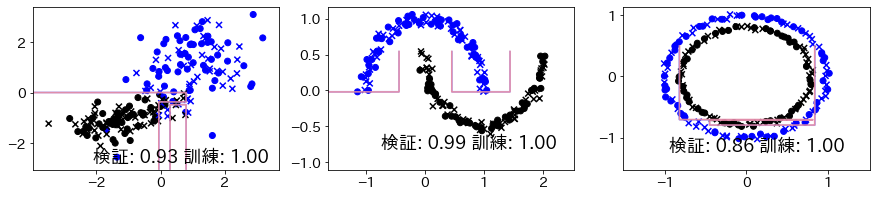

In [12]:
# 決定木の散布図・分類結果表示

# Algorithm の選択
algorithm = DecisionTreeClassifier(random_state=random_seed)

# Algorithm の持つ Parameters の表示
print(algorithm)

# 表示関数の呼び出し
plot_boundaries(algorithm, DataList)

### 決定木の性質

1. Support Vector Machine(Kernel) 同様、同心円状の決定境界にも対応できる。
2. Support Vector Machine(kernel) の境界線がなだらかな曲線だったのに対して、決定木の境界線は、長方形の矩形領域を組わせた図形になる。
3. 例外値に対してもむりやり適合する Rule を作るので、境界線が不自然な図形になる場合がある。

3.) の性質は決定木を Algorithm として Model を作る時の注意点になり、例外値に過剰に対応した Model を作ってしまい「過学習」になる。<small>※ 過学習は機械学習で最も気をつけるべきこと。</small>

決定木は、Tree の階層を深くすればするだけ**過学習の危険**が生じる。そこで、階層の深さを  Data に応じて最適なものに Tuning していく。

DecisionTreeClassifier(max_depth=3, random_state=123)


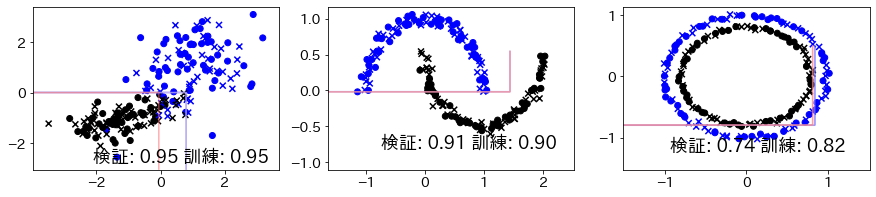

In [13]:
# 決定木の散布図・分類結果表示（max_depth=3 の場合）

# Algorithm 選択
algorithm = DecisionTreeClassifier(random_state=random_seed, max_depth=3)

# Algorithm の持つ Parameters の表示
print(algorithm)

# 表示関数の呼び出し
plot_boundaries(algorithm, DataList)

Default の階層にした Model に比べると、左側の Data が訓練 Data の精度は95%に落ちたが、検証 Data の精度が逆に95%に向上したことが確認できる。
左側の Data に関しては **「過学習が少なくなり、Model の汎用性が高くなった」**。

<small>
※ 右側の Data に対しては精度は悪化してしまっている。
</small>

## Random Forest
**決定木**の欠点は、過学習が起きやすいこと。この欠点を補うために考えられた方式。
Original Data から、Sample Data を Bootstrap 法で複数つくり、分類に使う変数を"あえて" Random に絞り込み **「弱分類器」（精度の低い決定木）** をたくさんつくる。それぞれの分類器の分類結果を集計して多数決で最終的な判断するという仕組み。
<small>
一見すると回りくどい方法だが、単純な決定木よりも過学習に強い Model ができる。
</small>

RandomForestClassifier(random_state=123)


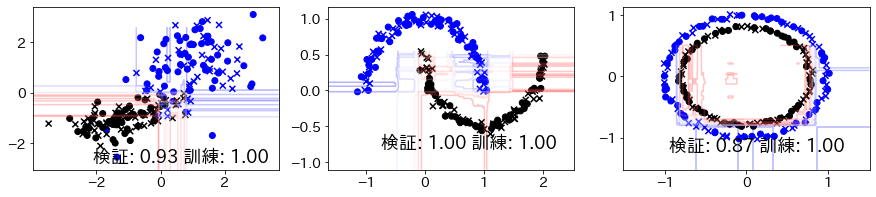

In [15]:
# Random Forest の散布図・分類結果表示

# Algorithm の選択
algorithm = RandomForestClassifier(random_state=random_seed)

# Algorithm の持つ Parameters の表示
print(algorithm)

# 表示関数の呼び出し
plot_boundaries(algorithm, DataList)